<style>
div.cell, div.text_cell_render{
  max-width:750px;
  margin-left:auto;
  margin-right:auto;
}

.rendered_html
{
  font-size: 140%;
  }

.rendered_html li
{
  line-height: 1.8;
  }

.rendered_html h1, h2 {
  text-align:center;
  font-familly:"Charis SIL", serif;
}
</style>

<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for UW's [Astro 599](http://www.astro.washington.edu/users/vanderplas/Astr599/) course. Source and license info is on [GitHub](https://github.com/jakevdp/2013_fall_ASTR599/).</i></small>

# Introduction to Scikit-Learn:
## Machine Learning with Python

Scikit-learn is a collection of tools for machine learning written in Python:
[http://scikit-learn.org](http://scikit-learn.org)

## Setup and installation
If you're using [Anaconda](https://store.continuum.io/cshop/anaconda/), simpy type

```
conda install scikit-learn
```

Otherwise it's best to install from source (requires a C compiler):
```
git clone https://github.com/scikit-learn/scikit-learn.git
cd scikit-learn
python setup.py install
```

Scikit-learn requires ``NumPy`` and ``SciPy``, and examples require ``Matplotlib``.

**Note**: some examples below require the scripts in the ``fig_code`` directory, which
can be found within the ``notebooks`` subdirectory of the Github repository at
[https://github.com/jakevdp/2013_fall_ASTR599/](https://github.com/jakevdp/2013_fall_ASTR599/)

## Outline for the Day

- What is machine learning?
- How is data represented in Scikit-learn?
- Introduction to the Scikit-learn API
- Basics of Machine Learning
  + Supervised learning: Classification & Regression
  + Unsupervised learning: Dimensionality Reduction & Clustering
- Astronomy Example: Classifying variable stars

*Much of this material is adapted from my [SciPy 2013 Tutorial](https://github.com/jakevdp/sklearn_scipy2013), with Gael Varoquaux and Olivier Grisel*

## What is Machine Learning?

In this section we will begin to explore the basic principles of machine learning.
Machine Learning is about building programs with **tunable parameters** (typically an
array of floating point values) that are adjusted automatically so as to improve
their behavior by **adapting to previously seen data.**

Machine Learning can be considered a subfield of **Artificial Intelligence** since those
algorithms can be seen as building blocks to make computers learn to behave more
intelligently by somehow **generalizing** rather that just storing and retrieving data items
like a database system would do.

We'll take a look at two very simple machine learning tasks here.
The first is a **classification** task: the figure shows a
collection of two-dimensional data, colored according to two different class
labels. A classification algorithm may be used to draw a dividing boundary
between the two clusters of points:

In [39]:
# start the inline backend for plotting
%matplotlib inline

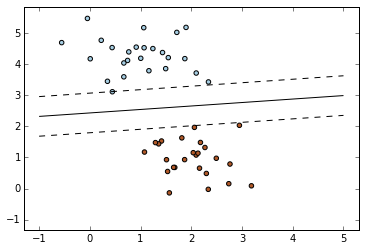

In [40]:
# Import the example plot from the figures directory
from fig_code import plot_sgd_separator
plot_sgd_separator()

This may seem like a trivial task, but it is a simple version of a very important concept.
By drawing this separating line, we have learned a model which can **generalize** to new
data: if you were to drop another point onto the plane which is unlabeled, this algorithm
could now **predict** whether it's a blue or a red point.

If you'd like to see the source code used to generate this, you can either open the
code in the `figures` directory, or you can load the code using the `%load` magic command:

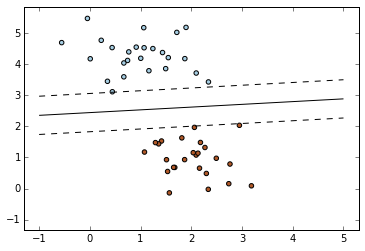

In [41]:
# %load fig_code/sgd_separator.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.datasets.samples_generator import make_blobs

def plot_sgd_separator():
    # we create 50 separable points
    X, Y = make_blobs(n_samples=50, centers=2,
                      random_state=0, cluster_std=0.60)

    # fit the model
    clf = SGDClassifier(loss="hinge", alpha=0.01,
                        n_iter=200, fit_intercept=True)
    clf.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    xx = np.linspace(-1, 5, 10)
    yy = np.linspace(-1, 5, 10)

    X1, X2 = np.meshgrid(xx, yy)
    Z = np.empty(X1.shape)
    for (i, j), val in np.ndenumerate(X1):
        x1 = val
        x2 = X2[i, j]
        p = clf.decision_function([x1, x2])
        Z[i, j] = p[0]
    levels = [-1.0, 0.0, 1.0]
    linestyles = ['dashed', 'solid', 'dashed']
    colors = 'k'

    ax = plt.axes()
    ax.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

    ax.axis('tight')


if __name__ == '__main__':
    plot_sgd_separator()
    plt.show()


The next simple task we'll look at is a **regression** task: a simple best-fit line
to a set of data:

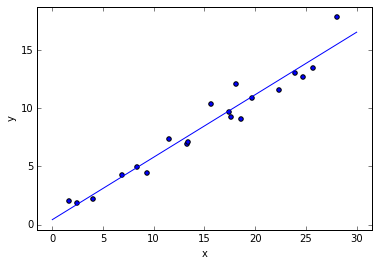

In [5]:
from fig_code import plot_linear_regression
plot_linear_regression()

Again, this is an example of fitting a model to data, such that the model can make
generalizations about new data.  The model has been **learned** from the training
data, and can be used to predict the result of test data:
here, we might be given an x-value, and the model would
allow us to predict the y value.  Again, this might seem like a trivial problem,
but it is a basic example of a type of operation that is fundamental to
machine learning tasks.

## Representation of Data in Scikit-learn

Machine learning is about creating models from data: for that reason, we'll start by
discussing how data can be represented in order to be understood by the computer.  Along
with this, we'll build on our matplotlib examples from the previous section and show some
examples of how to visualize data.

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, or in some cases ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify).
  A sample can be a document, a picture, a sound, a video, an astronomical object,
  a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each
  item in a quantitative manner.  Features are generally real-valued, but may be boolean or
  discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features) with most of them being zeros for a given sample. This is a case
where `scipy.sparse` matrices can be useful, in that they are
much more memory-efficient than numpy arrays.

## A Simple Example: the Iris Dataset

As an example of a simple dataset, we're going to take a look at the
iris data stored by scikit-learn.
The data consists of measurements of three different species of irises.
There are three species of iris in the dataset, which we can picture here:

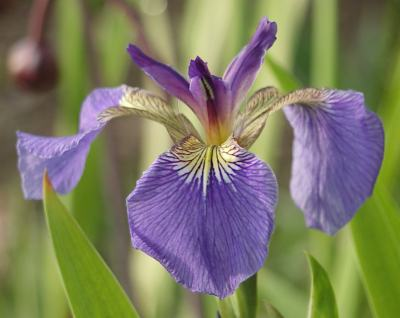

Iris Setosa



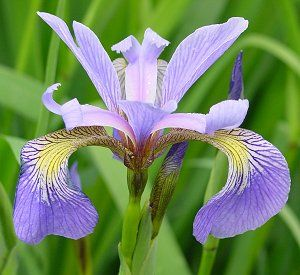

Iris Versicolor



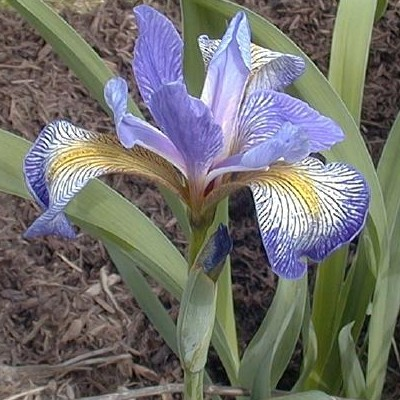

Iris Virginica


In [6]:
from IPython.core.display import Image, display
display(Image(filename='images/iris_setosa.jpg'))
print "Iris Setosa\n"

display(Image(filename='images/iris_versicolor.jpg'))
print "Iris Versicolor\n"

display(Image(filename='images/iris_virginica.jpg'))
print "Iris Virginica"

### Quick Question:

**If we want to design an algorithm to recognize iris species, what might the data be?**

Remember: we need a 2D array of size `[n_samples x n_features]`.

- What would the `n_samples` refer to?

- What might the `n_features` refer to?

Remember that there must be a **fixed** number of features for each sample, and feature
number ``i`` must be a similar kind of quantity for each sample.

### Loading the Iris Data with Scikit-Learn

Scikit-learn has a very straightforward set of data on these iris species.  The data consist of
the following:

- Features in the Iris dataset:

  1. sepal length in cm
  2. sepal width in cm
  3. petal length in cm
  4. petal width in cm

- Target classes to predict:

  1. Iris Setosa
  2. Iris Versicolour
  3. Iris Virginica
  
``scikit-learn`` embeds a copy of the iris CSV file along with a helper function to load it into numpy arrays:

In [7]:
from sklearn.datasets import load_iris
iris = load_iris()

In [8]:
iris.keys()

['target_names', 'data', 'target', 'DESCR', 'feature_names']

In [9]:
n_samples, n_features = iris.data.shape
print (n_samples, n_features)
print iris.data[0]

(150, 4)
[ 5.1  3.5  1.4  0.2]


In [20]:
print iris.data.shape
print iris.target.shape
print iris.feature_names

(150, 4)
(150,)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [15]:
print iris.target

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [21]:
print iris.target_names
print iris.DESCR

['setosa' 'versicolor' 'virginica']
Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:
    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================
    

This data is four dimensional, but we can visualize two of the dimensions
at a time using a simple scatter-plot:

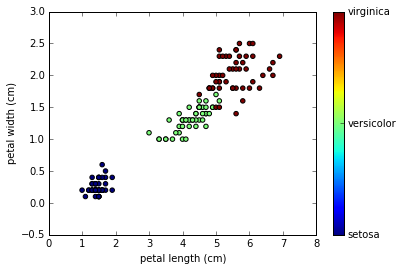

In [22]:
import numpy as np
import matplotlib.pyplot as plt

x_index = 2
y_index = 3

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

plt.scatter(iris.data[:, x_index], iris.data[:, y_index],
            c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index]);

### Quick Exercise:

**Change** `x_index` **and** `y_index` **in the above script
and find a combination of two parameters
which maximally separate the three classes.**

This exercise is a preview of **dimensionality reduction**, which we'll see later.

## Other Available Data
They come in three flavors:

- **Packaged Data:** these small datasets are packaged with the scikit-learn installation,
  and can be downloaded using the tools in ``sklearn.datasets.load_*``
- **Downloadable Data:** these larger datasets are available for download, and scikit-learn
  includes tools which streamline this process.  These tools can be found in
  ``sklearn.datasets.fetch_*``
- **Generated Data:** there are several datasets which are generated from models based on a
  random seed.  These are available in the ``sklearn.datasets.make_*``

You can explore the available dataset loaders, fetchers, and generators using IPython's
tab-completion functionality.  After importing the ``datasets`` submodule from ``sklearn``,
type

    datasets.load_ + TAB

or

    datasets.fetch_ + TAB

or

    datasets.make_ + TAB

to see a list of available functions.

In [23]:
from sklearn import datasets

In [24]:
datasets.fetch_olivetti_faces()

downloading Olivetti faces from http://cs.nyu.edu/~roweis/data/olivettifaces.mat to /Users/karthik/scikit_learn_data


{'DESCR': 'Modified Olivetti faces dataset.\n\nThe original database was available from (now defunct)\n\n    http://www.uk.research.att.com/facedatabase.html\n\nThe version retrieved here comes in MATLAB format from the personal\nweb page of Sam Roweis:\n\n    http://www.cs.nyu.edu/~roweis/\n\nThere are ten different images of each of 40 distinct subjects. For some\nsubjects, the images were taken at different times, varying the lighting,\nfacial expressions (open / closed eyes, smiling / not smiling) and facial\ndetails (glasses / no glasses). All the images were taken against a dark\nhomogeneous background with the subjects in an upright, frontal position (with\ntolerance for some side movement).\n\nThe original dataset consisted of 92 x 112, while the Roweis version\nconsists of 64x64 images.\n',
 'data': array([[ 0.30991736,  0.36776859,  0.41735536, ...,  0.15289256,
          0.16115703,  0.1570248 ],
        [ 0.45454547,  0.47107437,  0.51239669, ...,  0.15289256,
          0.1

## Basic Principles of Machine Learning

Here we'll dive into the basic principles of machine learning, and how to
utilize them via the Scikit-Learn API.

After briefly introducing scikit-learn's *Estimator* object, we'll cover **supervised learning**, including *classification* and *regression* problems, and **unsupervised learning**, including *dimensinoality reduction* and *clustering* problems.

### The Scikit-learn Estimator Object

Every algorithm is exposed in scikit-learn via an ''Estimator'' object. For instance a linear regression is implemented as so:

In [25]:
from sklearn.linear_model import LinearRegression

**Estimator parameters**: All the parameters of an estimator can be set when it is instantiated, and have suitable default values:

In [26]:
model = LinearRegression(normalize=True)
print model.normalize

True


In [27]:
print model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


**Estimated Model parameters**: When data is *fit* with an estimator, parameters are estimated from the data at hand. All the estimated parameters are attributes of the estimator object ending by an underscore:

In [28]:
x = np.array([0, 1, 2])
y = np.array([0, 1, 2])

(-0.5, 2.5)

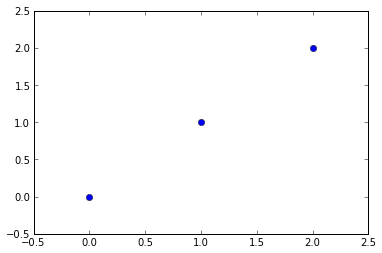

In [20]:
plt.plot(x, y, 'o')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 2.5)

In [30]:
# The input data for sklearn is 2D: (samples == 3 x features == 1)
X = x[:, np.newaxis]
print X
print y

[[0]
 [1]
 [2]]
[0 1 2]


In [31]:
model.fit(X, y) 
print model.coef_
print model.intercept_

[ 1.]
1.11022302463e-16


In [24]:
model.residues_

1.2325951644078309e-32

The model found a line with a slope 1 and intercept 0, as we'd expect.

### Supervised Learning: Classification and Regression

In **Supervised Learning**, we have a dataset consisting of both features and labels.
The task is to construct an estimator which is able to predict the label of an object
given the set of features. A relatively simple example is predicting the species of 
iris given a set of measurements of its flower. This is a relatively simple task. 
Some more complicated examples are:

- given a multicolor image of an object through a telescope, determine
  whether that object is a star, a quasar, or a galaxy.
- given a photograph of a person, identify the person in the photo.
- given a list of movies a person has watched and their personal rating
  of the movie, recommend a list of movies they would like
  (So-called *recommender systems*: a famous example is the [Netflix Prize](http://en.wikipedia.org/wiki/Netflix_prize)).

What these tasks have in common is that there is one or more unknown
quantities associated with the object which needs to be determined from other
observed quantities.

Supervised learning is further broken down into two categories, **classification** and **regression**.
In classification, the label is discrete, while in regression, the label is continuous. For example,
in astronomy, the task of determining whether an object is a star, a galaxy, or a quasar is a
classification problem: the label is from three distinct categories. On the other hand, we might
wish to estimate the age of an object based on such observations: this would be a regression problem,
because the label (age) is a continuous quantity.

#### Classification Example
K nearest neighbors (kNN) is one of the simplest learning strategies: given a new, unknown observation, look up in your reference database which ones have the closest features and assign the predominant class.

Let's try it out on our iris classification problem:

In [32]:
from sklearn import neighbors, datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target

# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors=1)

# fit the model
knn.fit(X, y)

# What kind of iris has 3cm x 5cm sepal and 4cm x 2cm petal?
# call the "predict" method:
result = knn.predict([[3, 5, 4, 2],])

print iris.target_names[result]

['virginica']


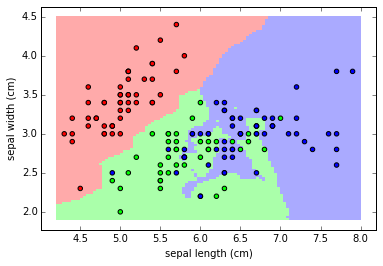

In [33]:
from fig_code import plot_iris_knn
plot_iris_knn()

**Exercise**: Now use as an estimator on the same problem: ``sklearn.svm.SVC``.

> Note that you don't have to know what it is do use it.

> If you finish early, do the same plot as above.

In [34]:
from sklearn.svm import SVC

['virginica']


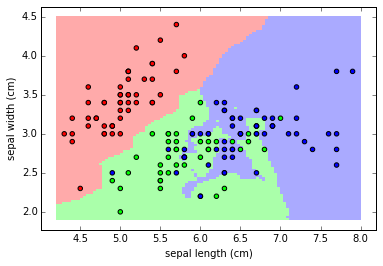

In [37]:
model = SVC()
model.fit(X, y)
result = model.predict([[3, 5, 4, 2],])
print iris.target_names[result]


from fig_code import plot_iris_knn
plot_iris_knn()

#### Regression Example

Simplest possible regression is fitting a line to data:

Model coefficient: 3.93491, and intercept: 1.46229


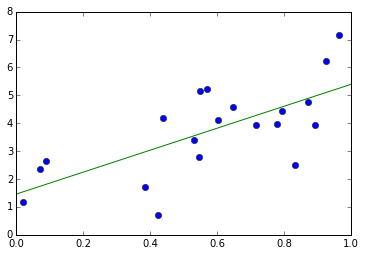

In [38]:
# Create some simple data
import numpy as np
np.random.seed(0)
X = np.random.random(size=(20, 1))
y = 3 * X.squeeze() + 2 + np.random.normal(size=20)

# Fit a linear regression to it
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
print ("Model coefficient: %.5f, and intercept: %.5f"
       % (model.coef_, model.intercept_))

# Plot the data and the model prediction
X_test = np.linspace(0, 1, 100)[:, np.newaxis]
y_test = model.predict(X_test)

plt.plot(X.squeeze(), y, 'o')
plt.plot(X_test.squeeze(), y_test);

### Unsupervised Learning: Dimensionality Reduction and Clustering

**Unsupervised Learning** addresses a different sort of problem. Here the data has no labels,
and we are interested in finding similarities between the objects in question. In a sense,
you can think of unsupervised learning as a means of discovering labels from the data itself.
Unsupervised learning comprises tasks such as *dimensionality reduction*, *clustering*, and
*density estimation*. For example, in the iris data discussed above, we can used unsupervised
methods to determine combinations of the measurements which best display the structure of the
data. As we'll see below, such a projection of the data can be used to visualize the
four-dimensional dataset in two dimensions. Some more involved unsupervised learning problems are:

- given detailed observations of distant galaxies, determine which features or combinations of
  features best summarize the information.
- given a mixture of two sound sources (for example, a person talking over some music),
  separate the two (this is called the [blind source separation](http://en.wikipedia.org/wiki/Blind_signal_separation) problem).
- given a video, isolate a moving object and categorize in relation to other moving objects which have been seen.

Sometimes the two may even be combined: e.g. Unsupervised learning can be used to find useful
features in heterogeneous data, and then these features can be used within a supervised
framework.

#### Dimensionality Reduction: PCA

Principle Component Analysis (PCA) is a dimension reduction technique that can find the combinations of variables that explain the most variance.

Consider the iris dataset. It cannot be visualized in a single 2D plot, as it has 4 features. We are going to extract 2 combinations of sepal and petal dimensions to visualize it:

Reduced dataset shape: (150, 2)
Meaning of the 2 components:
0.362 x sepal length (cm) + -0.082 x sepal width (cm) + 0.857 x petal length (cm) + 0.359 x petal width (cm)
-0.657 x sepal length (cm) + -0.730 x sepal width (cm) + 0.176 x petal length (cm) + 0.075 x petal width (cm)


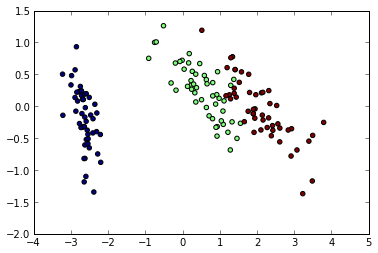

In [40]:
X, y = iris.data, iris.target
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
print "Reduced dataset shape:", X_reduced.shape

import pylab as pl
pl.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)

print "Meaning of the 2 components:"
for component in pca.components_:
    print " + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names))

#### Clustering: K-means

Clustering groups together observations that are homogeneous with respect to a given criterion, finding ''clusters'' in the data.

Note that these clusters will uncover relevent hidden structure of the data only if the criterion used highlights it.

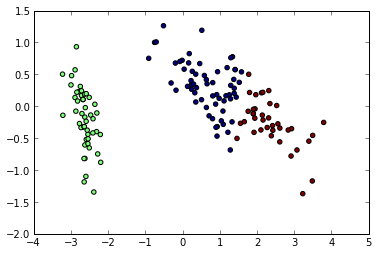

In [41]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0) # Fixing the RNG in kmeans
k_means.fit(X)
y_pred = k_means.predict(X)

pl.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred);

### Recap: Scikit-learn's estimator interface

Scikit-learn strives to have a uniform interface across all methods,
and we'll see examples of these below. Given a scikit-learn *estimator*
object named `model`, the following methods are available:

- Available in **all Estimators**
  + `model.fit()` : fit training data. For supervised learning applications,
    this accepts two arguments: the data `X` and the labels `y` (e.g. `model.fit(X, y)`).
    For unsupervised learning applications, this accepts only a single argument,
    the data `X` (e.g. `model.fit(X)`).
- Available in **supervised estimators**
  + `model.predict()` : given a trained model, predict the label of a new set of data.
    This method accepts one argument, the new data `X_new` (e.g. `model.predict(X_new)`),
    and returns the learned label for each object in the array.
  + `model.predict_proba()` : For classification problems, some estimators also provide
    this method, which returns the probability that a new observation has each categorical label.
    In this case, the label with the highest probability is returned by `model.predict()`.
  + `model.score()` : for classification or regression problems, most (all?) estimators implement
    a score method.  Scores are between 0 and 1, with a larger score indicating a better fit.
- Available in **unsupervised estimators**
  + `model.transform()` : given an unsupervised model, transform new data into the new basis.
    This also accepts one argument `X_new`, and returns the new representation of the data based
    on the unsupervised model.
  + `model.fit_transform()` : some estimators implement this method,
    which more efficiently performs a fit and a transform on the same input data.

## Exercises

Here we'll show a couple examples of machine learning on astronomical data.
For many more examples, see the [AstroML](http://astroml.org) website.

### Classification: Labeling Photometric Sources

Here we'll do some automated classification of photometric sources.
First the data, which can be fetched via ``astroML``.  If you don't have
astroML installed, use ``pip install astroML``

In [42]:
from astroML.datasets import fetch_rrlyrae_combined
from sklearn.cross_validation import train_test_split

X, y = fetch_rrlyrae_combined()

# For now, we'll only fit the first two colors
X_train, X_test, y_train, y_test = train_test_split(X, y)

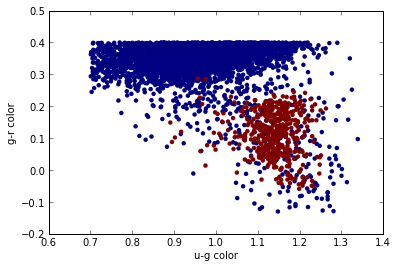

In [43]:
N_plot = 5000
plt.scatter(X[-N_plot:, 0], X[-N_plot:, 1], c=y[-N_plot:],
            edgecolors='none')
plt.xlabel('u-g color')
plt.ylabel('g-r color');

Red points are RR-Lyrae, Blue points are main sequence stars.

Now we'll do a simple and fast $K$-neighbors classification.

Note that we train on part of the data and test on another part.  Otherwise,
an estimator which simply remembers the entire dataset would obtain a perfect
classification!

In [44]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [45]:
print np.sum(y_pred == y_test)
print np.sum(y_pred != y_test)

23203
83


In [46]:
from sklearn.metrics import classification_report
print classification_report(y_test, y_pred,
                            target_names=['MS star', 'RR Lyrae'])

             precision    recall  f1-score   support

    MS star       1.00      1.00      1.00     23185
   RR Lyrae       0.58      0.62      0.60       101

avg / total       1.00      1.00      1.00     23286



#### Note on the meaning of these terms:

$$
{\rm precision} \equiv \frac{\rm true~positives}{\rm true~positives + false~positives}
$$

$$
{\rm recall} \equiv \frac{\rm true~positives}{\rm true~positives + false~negatives}
$$

$$ F_1 \equiv \frac{\rm precision \cdot recall}{\rm precision + recall}
$$

The range for precision, recall, and F1 score is 0 to 1, with 1 being perfect.
Often in astronomy, we call the recall the *completeness*, and (1 - precision) the *contamination*.

Because this is an *unbalanced* dataset, we see that the RR Lyrae stars are completely overwhelmed by the larger number of normal Main Sequence stars.

### Exercise 1: Classification of RR Lyrae

Use another classifier and try to improve on this precision/recall score.

There are several you might try:

- ``sklearn.neighbors.GaussianNaiveBayes`` (slow but inaccurate)
- ``sklearn.lda.LDA`` (slow but inaccurate)
- ``sklearn.svm.SVC`` (fast but accurate)
- ``sklearn.svm.SVC`` with ``kernel='rbf'`` (fast but accurate)
- ``sklearn.ensemble.RandomForestClassifier`` (fast & potentially accurate with tuning)

For the slower algorithms, it might be a good idea to use only part of the dataset as you experiment, i.e. when training do something like the following:

```
clf.fit(X_train[::5], y_train[::5])
```

Once you're happy, you can run the training on the full dataset.

What's the best precision/recall you can obtain for the RR-Lyrae data?

### Regression: Photometric Redshifts

The photometric redshift problem is a classic *Regression* problem

In [47]:
from astroML.datasets import fetch_sdss_specgals

In [48]:
data = fetch_sdss_specgals()

# put magnitudes in a matrix
X = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
y = data['z']

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [49]:
from sklearn.linear_model import LinearRegression
est = LinearRegression()
est.fit(X_train, y_train)
y_pred = est.predict(X_test)

(0, 0.6)

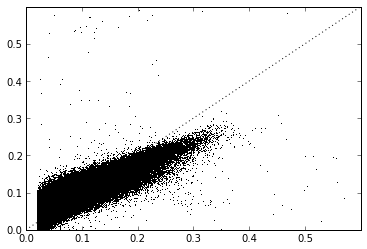

In [50]:
plt.plot(y_test, y_pred, ',k')
plt.plot([0, 1], [0, 1], ':k')
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)

Evidently, a simple linear model is not a very good fit!

Let's compute the RMS deviation to see how poor this actually is:

In [51]:
rms = np.sqrt(np.mean((y_test - y_pred) ** 2))
print rms

0.0332893212347


### Exercise 2

Try to improve on this result using another regression algorithm.  Some potential choices:

- ``sklearn.neighbors.KNeighborsRegressor`` (fast-ish, but often inaccurate
- ``sklearn.svm.SVR`` (potentially accurate, but slow)
- ``sklearn.ensemble.RandomForestRegressor`` (fast, and accurate with tuning)
- ``sklearn.ensemble.GradientBoostingRegressor`` (accurate with tuning, can be very slow depending on parameters)

Again, sub-sampling the data can help as you explore some of the slower techniques.

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
RandomForestClassifier?

## Where to Find More

There's lots more information out there.

A couple of resources I've worked on:

- [Scikit-learn documentation](http://scikit-learn.org): lots of info and examples.
- [Scikit-learn Astronomy tutorial](http://astroml.org/sklearn_tutorial/): a bit outdated, but still has some interesting examples
- [AstroML](http://astroML.org): examples from our upcoming textbook (see especially the "book figures" tab)
- Scipy 2013 Tutorial: An eight hour tutorial on scikit-learn, presented by Olivier Grisel, Gael Varoquaux, and myself.  See the [videos](http://pyvideo.org/search?models=videos.video&q=intro+to+scikit-learn) and the [notebooks](https://github.com/jakevdp/sklearn_scipy2013).
